In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator

import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
from collections import namedtuple
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

In [2]:
Transaction = namedtuple("Transaction", ["Date", "Amount", "From", "To", "Description", "Notes"], defaults=[""])

In [3]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]
ACCT_NAMES = ["Type", "Account", "Subaccount"]
INST_ACCOUNTS = ["Assets:1st Source:Checking",
                 "Assets:Fidelity:HSA",
                 "Assets:Ally:Savins",
                 "Liabilities:NDFCU:Credit Card",
                 "Liabilities:Apple:Credit Card",
                 "Liabilities:Apple:Installments"]

In [4]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [5]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]
#np.max(apl["Transaction Date"])

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [6]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]
apl_inc.loc[4, "From"] = "Liabilities:Apple:Credit Card"
apl_inc



Date                                        Description    Amount  \
0 2022-05-20  iPhone - Apple Store MISHAWAKA IN TRANSACTION ... -1,299.00   
1 2022-05-20  iPhone AppleCare - Apple Store MISHAWAKA IN TR...   -199.00   
2 2024-02-09  Mac Pro M3 - Apple Online Store Cupertino CA T... -1,369.00   
3 2024-02-09  Mac Pro M3 AppleCare - Apple Online Store Cupe...   -279.00   
4 2022-05-31                               Manual Iphone Payoff    414.12   

                            From  
0           Expenses:Electronics  
1           Expenses:Electronics  
2           Expenses:Electronics  
3           Expenses:Electronics  
4  Liabilities:Apple:Credit Card

In [7]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]
#fst["Date"].max()

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [8]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

ally[ally["From"] == ""]
#ally.sort_values("Date")
#fd["Assets:Ally:Savings"]

Empty DataFrame
Columns: [Date, Time, Amount, Type, Description, From]
Index: []

In [9]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu["Description"] = ndfcu["Description"].fillna("")
ndfcu["Balance"] = ndfcu["Balance"].apply(ci.strip_currency).apply(float)
#ndfcu[ndfcu["From"] == ""]
ndfcu = ndfcu.sort_values(["Date", "Balance"])
ndfcu[pd.isnull(ndfcu["From"])]
ndfcu[ndfcu["Date"] >= pd.Timestamp("2024-08-31")]

Date              Note  \
1 2024-08-31    CC SALES DRAFT   
0 2024-08-31  FIN CHG PURCHASE   

                                         Description  Amount  Balance  \
1  CHEWY.COM                . 800-672-4399 . FL 0000 -273.57 1,305.97   
0                                                      -9.20 1,315.17   

                From  
1       Expenses:Pet  
0  Expenses:Interest

In [10]:
try:
    del hsa
except NameError:
    pass
hsa = ci.ingest_bank_files(fd["Assets:Fidelity:HSA"]["files"],
                           fd["Assets:Fidelity:HSA"],
                           RULESPTH)
hsa = hsa.rename(columns={"Run Date": "Date",
                          "Action": "Description",
                          "Description": "Note",
                          "Amount ($)": "Amount",
                          
                         }
                )

hsa = ci.read_and_apply(hsa, RULESPTH / fd["Assets:Fidelity:HSA"]["rules_file"])
hsa[hsa["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Symbol, Note, Type, Quantity, Price ($), Commission ($), Fees ($), Accrued Interest ($), Amount, Cash Balance ($), Settlement Date, From]
Index: []

In [11]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc,
              "Assets:Fidelity:HSA": hsa}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")

In [12]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])
bal_decl

Date                         Account  Statement Balance
0  2024-08-31  Liabilities:Apple:Installments            -824.02
1  2024-08-31   Liabilities:Apple:Credit Card          -3,424.48
2  2024-04-18             Assets:Ally:Savings          11,604.81
3  2024-03-18             Assets:Ally:Savings          10,965.45
4  2024-02-18             Assets:Ally:Savings          10,330.00
5  2024-04-30   Liabilities:NDFCU:Credit Card            -501.39
6  2024-03-31   Liabilities:NDFCU:Credit Card          -1,570.40
7  2024-02-29   Liabilities:NDFCU:Credit Card          -1,758.27
8  2024-01-31   Liabilities:NDFCU:Credit Card          -1,565.79
9  2024-01-31             Assets:Fidelity:HSA           3,956.09
10 2024-08-31             Assets:Fidelity:HSA           6,524.05
11 2024-01-30      Assets:1st Source:Checking           1,297.66
12 2024-08-29      Assets:1st Source:Checking             622.49
13 2024-07-30      Assets:1st Source:Checking           8,365.45
14 2024-01-18             Assets:Ally:Savings           9,694.18
15 2022-12-07             Assets:Ally:Savings               0.00
16 2023-12-31   Liabilities:NDFCU:Credit Card             -99.77
17 2024-08-31   Liabilities:NDFCU:Credit Card          -1,315.17
18 2023-12-31  Liabilities:Apple:Installments            -312.21
19 2023-12-31   Liabilities:Apple:Credit Card            -284.77
20 2023-12-31             Assets:Fidelity:HSA           3,939.33
21 2022-12-31             Assets:Fidelity:HSA               0.00
22 2023-12-31      Assets:1st Source:Checking           2,320.59
23 2023-12-18             Assets:Ally:Savings          10,058.08
24 2024-08-18             Assets:Ally:Savings           1,495.04
25 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
26 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
27 2023-11-30  Liabilities:Apple:Installments            -374.62
28 2023-11-30   Liabilities:Apple:Credit Card            -201.50
29 2023-11-18             Assets:Ally:Savings           9,425.23
30 2023-10-31   Liabilities:NDFCU:Credit Card          -2,492.89
31 2023-10-31  Liabilities:Apple:Installments            -437.03
32 2023-10-31   Liabilities:Apple:Credit Card            -151.48
33 2023-10-18             Assets:Ally:Savings           8,793.47
34 2023-09-30   Liabilities:NDFCU:Credit Card          -1,581.47
35 2023-08-31   Liabilities:NDFCU:Credit Card             -69.79
36 2023-07-31   Liabilities:NDFCU:Credit Card          -3,172.26
37 2023-06-30   Liabilities:NDFCU:Credit Card          -1,409.14
38 2023-05-31   Liabilities:NDFCU:Credit Card            -351.48
39 2023-04-30   Liabilities:NDFCU:Credit Card          -3,924.01
40 2023-03-31   Liabilities:NDFCU:Credit Card          -2,519.52
41 2023-02-28   Liabilities:NDFCU:Credit Card            -885.51
42 2023-01-31   Liabilities:NDFCU:Credit Card          -1,376.20
43 2022-12-31   Liabilities:NDFCU:Credit Card             -76.69
44 2021-12-31   Liabilities:NDFCU:Credit Card          -1,607.54
45 2022-01-01           Liabilities:Auto:Loan          -4,216.71
46 2021-12-31  Liabilities:Apple:Installments            -552.08
47 2021-12-31   Liabilities:Apple:Credit Card          -2,522.77
48 2021-12-31      Assets:1st Source:Checking           5,067.54
49 2021-12-31             Assets:Ally:Savings           8,028.68

In [13]:
trans = pd.concat([trans, ci.gen_init_balance_trans(bal_decl)], ignore_index=True).sort_values("Date")
#trans[trans["To"] == "Assets:Fidelity:HSA"]

In [14]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
#ledgers = ci.trans_to_ledgers(trans, bal_decl=bal_decl)
#ledgers[ledgers["Account"] == "Assets:1st Source:Checking"]
#ledgers[ledgers["Transaction Pair"] == "Liabilities:Auto:Loan"]
fg = trans.groupby("From")
tg = trans.groupby("To")
fl = {}
for acct in fg.groups:
    fl[acct] = trans.loc[fg.groups[acct]][["Date", "Description", "To"]].rename(columns={"To": "Transaction Pair"})
                                                                                                       
    fl[acct]["Incoming Amount"] = - 1 * trans.loc[fg.groups[acct]]["Amount"]
    fl[acct]["Account String"] = [acct] * len(fl[acct])

tl = {}
for acct in tg.groups:
    tl[acct] = trans.loc[tg.groups[acct]][["Date", "Description", "From"]].rename(columns={"From": "Transaction Pair"})
                                                                                                       
    tl[acct]["Incoming Amount"] = trans.loc[tg.groups[acct]]["Amount"]
    tl[acct]["Account String"] = [acct] * len(tl[acct])

ledgers = pd.concat(list(tl.values()) + list(fl.values())).sort_values("Date", ignore_index=True)

# Split account string to tuples.
acct_tuples = ledgers["Account String"].apply(lambda t:ci.to_triple(t, fill="")).apply(pd.Series).rename(columns=dict(zip(range(3), ACCT_NAMES)))
ledgers = pd.concat([ledgers, acct_tuples], axis="columns")

# Calculate cumulative balance.
ledgers["Balance"] = ledgers.groupby("Account String")["Incoming Amount"].cumsum()
ledgers[ledgers["Account String"] == "Liabilities:Apple:Installments"]

Date                                        Description  \
6    2021-12-31                                    Initial Balance   
138  2022-01-31                     MONTHLY INSTALLMENTS (9 OF 24)   
139  2022-01-31                     MONTHLY INSTALLMENTS (9 OF 24)   
255  2022-02-28                    MONTHLY INSTALLMENTS (10 OF 24)   
257  2022-02-28                    MONTHLY INSTALLMENTS (10 OF 24)   
406  2022-03-31                    MONTHLY INSTALLMENTS (11 OF 24)   
408  2022-03-31                    MONTHLY INSTALLMENTS (11 OF 24)   
601  2022-04-30                    MONTHLY INSTALLMENTS (12 OF 24)   
602  2022-04-30                    MONTHLY INSTALLMENTS (12 OF 24)   
732  2022-05-20  iPhone AppleCare - Apple Store MISHAWAKA IN TR...   
736  2022-05-20  iPhone - Apple Store MISHAWAKA IN TRANSACTION ...   
789  2022-05-31                     MONTHLY INSTALLMENTS (1 OF 24)   
790  2022-05-31                     MONTHLY INSTALLMENTS (1 OF 24)   
796  2022-05-31                               Manual Iphone Payoff   
952  2022-06-30                     MONTHLY INSTALLMENTS (2 OF 24)   
953  2022-06-30                     MONTHLY INSTALLMENTS (2 OF 24)   
1162 2022-07-31                     MONTHLY INSTALLMENTS (3 OF 24)   
1169 2022-07-31                     MONTHLY INSTALLMENTS (3 OF 24)   
1332 2022-08-31                     MONTHLY INSTALLMENTS (4 OF 24)   
1337 2022-08-31                     MONTHLY INSTALLMENTS (4 OF 24)   
1517 2022-09-30                     MONTHLY INSTALLMENTS (5 OF 24)   
1518 2022-09-30                     MONTHLY INSTALLMENTS (5 OF 24)   
1714 2022-10-31                     MONTHLY INSTALLMENTS (6 OF 24)   
1721 2022-10-31                     MONTHLY INSTALLMENTS (6 OF 24)   
1900 2022-11-30                     MONTHLY INSTALLMENTS (7 OF 24)   
1901 2022-11-30                     MONTHLY INSTALLMENTS (7 OF 24)   
2180 2022-12-31                     MONTHLY INSTALLMENTS (8 OF 24)   
2181 2022-12-31                     MONTHLY INSTALLMENTS (8 OF 24)   
2345 2023-01-31                     MONTHLY INSTALLMENTS (9 OF 24)   
2349 2023-01-31                     MONTHLY INSTALLMENTS (9 OF 24)   
2480 2023-02-28                    MONTHLY INSTALLMENTS (10 OF 24)   
2490 2023-02-28                    MONTHLY INSTALLMENTS (10 OF 24)   
2685 2023-03-31                    MONTHLY INSTALLMENTS (11 OF 24)   
2686 2023-03-31                    MONTHLY INSTALLMENTS (11 OF 24)   
2832 2023-04-30                    MONTHLY INSTALLMENTS (12 OF 24)   
2840 2023-04-30                    MONTHLY INSTALLMENTS (12 OF 24)   
3019 2023-05-31                    MONTHLY INSTALLMENTS (13 OF 24)   
3020 2023-05-31                    MONTHLY INSTALLMENTS (13 OF 24)   
3266 2023-06-30                    MONTHLY INSTALLMENTS (14 OF 24)   
3268 2023-06-30                    MONTHLY INSTALLMENTS (14 OF 24)   
3416 2023-07-31                    MONTHLY INSTALLMENTS (15 OF 24)   
3428 2023-07-31                    MONTHLY INSTALLMENTS (15 OF 24)   
3608 2023-08-31                    MONTHLY INSTALLMENTS (16 OF 24)   
3611 2023-08-31                    MONTHLY INSTALLMENTS (16 OF 24)   
3770 2023-09-30                    MONTHLY INSTALLMENTS (17 OF 24)   
3781 2023-09-30                    MONTHLY INSTALLMENTS (17 OF 24)   
3982 2023-10-31                    MONTHLY INSTALLMENTS (18 OF 24)   
3997 2023-10-31                    MONTHLY INSTALLMENTS (18 OF 24)   
4205 2023-11-30                    MONTHLY INSTALLMENTS (19 OF 24)   
4206 2023-11-30                    MONTHLY INSTALLMENTS (19 OF 24)   
4406 2023-12-31                    MONTHLY INSTALLMENTS (20 OF 24)   
4408 2023-12-31                    MONTHLY INSTALLMENTS (20 OF 24)   
4564 2024-01-31                    MONTHLY INSTALLMENTS (21 OF 24)   
4566 2024-01-31                    MONTHLY INSTALLMENTS (21 OF 24)   
4638 2024-02-09  Mac Pro M3 AppleCare - Apple Online Store Cupe...   
4639 2024-02-09  Mac Pro M3 - Apple Online Store Cupertino CA T...   
4781 2024-02-29      

# Ledger Table with Zeros

In [15]:
lw0 = ledgers
#lw0 = lw0.set_index("Date")
daily = pd.date_range(start=lw0["Date"].min(), end=lw0["Date"].max(), freq="1D")
def add_dates(df):
    datesnotin = daily[~daily.isin(df["Date"])]
    newdf = pd.DataFrame({"Date": datesnotin,
                          "Incoming Amount": [0.0] * len(datesnotin),
                          "Description": ["Fake Zero"] * len(datesnotin)
                         })
    newdf = pd.concat([df, newdf]).sort_values("Date")
    #print(newdf)
    cols=["Transaction Pair", "Account String", "Balance"]
    newdf.loc[:, cols]  = newdf.loc[:, cols].ffill()
    newdf.loc[:, ["Transaction Pair", "Account String"]] = newdf.loc[:, ["Transaction Pair", "Account String"]].bfill()
    #print(newdf)
    newdf["Balance"] = newdf["Balance"].fillna(0.0)
    return newdf
    
lw0 = lw0.groupby(ACCT_NAMES).apply(add_dates, include_groups=False)
lw0=lw0.reset_index().drop(columns="level_3").sort_values("Date")

In [16]:
#g = ledge_with_acct["Incoming Amount"].groupby(ledge_with_acct.index).sum("Incoming Amount")
# Select all lines with an initial balance.

clear_virtuals=True

start_date = None
end_date = None #date(2024,1,1)

ltable = ledgers

if start_date is not None:
    ltable = ltable[ltable["Date"] >= pd.Timestamp(start_date)]
if end_date is not None:
    ltable = ltable[ltable["Date"] <= pd.Timestamp(end_date)]


# Group on Accounts
acct_g = ltable.groupby(ACCT_NAMES)

# Choose first and last date of each group from ltable, reassign with column names and set account as multiindex.
start = acct_g.head(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "Start Date", "Balance": "Initial Balance"}).set_index(ACCT_NAMES)
end = acct_g.tail(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "End Date", "Balance": "End Balance"}).set_index(ACCT_NAMES)

#br = br.set_index(pd.MultiIndex.from_tuples(br.index.to_series().apply(ci.to_triple), names=["Type", "Account", "Subaccount"])a
br = pd.concat([start, end],axis="columns")
br["Difference"] = br["End Balance"] - br["Initial Balance"]
br
#acct_g["Date"].groups["Expenses:Reimbursible"]

Start Date  Initial Balance  \
Type        Account          Subaccount                                     
Assets      1st Source       Checking         2021-12-31         5,067.54   
Liabilities Apple            Credit Card      2021-12-31           -11.04   
            NDFCU            Credit Card      2021-12-31           -26.93   
Equity      Initial Balance                   2021-12-31           552.08   
Liabilities Apple            Installments     2021-12-31          -552.08   
Assets      Ally             Savings          2021-12-31         8,028.68   
Expenses    Subscriptions                     2021-12-31            14.99   
            Entertainment                     2021-12-31            11.04   
            Auto             Fuel             2021-12-31            26.93   
            Groceries                         2021-12-31            86.95   
            Medical          Body             2022-01-01            24.70   
Liabilities Auto             Loan             2022-01-01        -4,216.71   
Expenses    Home             Mortgage         2022-01-03           674.34   
            Clothing                          2022-01-04            63.88   
            Utilities                         2022-01-05            17.12   
            Gear                              2022-01-05           385.15   
            Personal                          2022-01-06            36.00   
Transfer                                      2022-01-06         2,000.00   
Expenses    Medical          Therapy          2022-01-07            35.00   
            Cash                              2022-01-10           100.00   
            Misc                              2022-01-13             9.16   
            Auto                              2022-01-14             9.62   
            Amazon                            2022-01-15            12.99   
            Home                              2022-01-16             5.99   
Income      Interest                          2022-01-18            -3.05   
Expenses    Pet                               2022-01-19           123.08   
            Fitness                           2022-01-24           225.00   
Income      Notre Dame       Regular          2022-01-31        -4,507.79   
Expenses    Auto             Maintenance      2022-02-07            14.00   
            Restaurants                       2022-02-09             1.20   
            Pet              Care             2022-02-11            90.00   
            Study                             2022-02-17            53.22   
            Entertainment    Personal         2022-02-21            34.95   
                             Self             2022-03-13            84.95   
            Home             Furnishings      2022-03-27           156.22   
                             Maintenance      2022-04-05           667.00   
            Auto             Registration     2022-04-10           541.92   
Income      Taxes                             2022-04-10           108.00   
Expenses    Reimbursable                      2022-04-18           -20.00   
            Projects                          2022-04-19           137.36   
            Charity                           2022-04-25            37.10   
            Entertainment    Reading          2022-05-03           171.19   
            Medical          Recovery         2022-05-13            55.00   
            Fitness          Equipment        2022-05-16           100.00   
            Electronics                       2022-05-20         1,299.00   
            Home Furnishings                  2022-05-30         1,599.78   
            Auto             Insurance        2022-06-10           444.90   
            Fitness          ID               2022-06-24           225.00   
Income      Apple Cash                        2022-07-29             2.12   
Expenses    Home             Repairs          2022-08-02         5,600.00   
            Interest                      

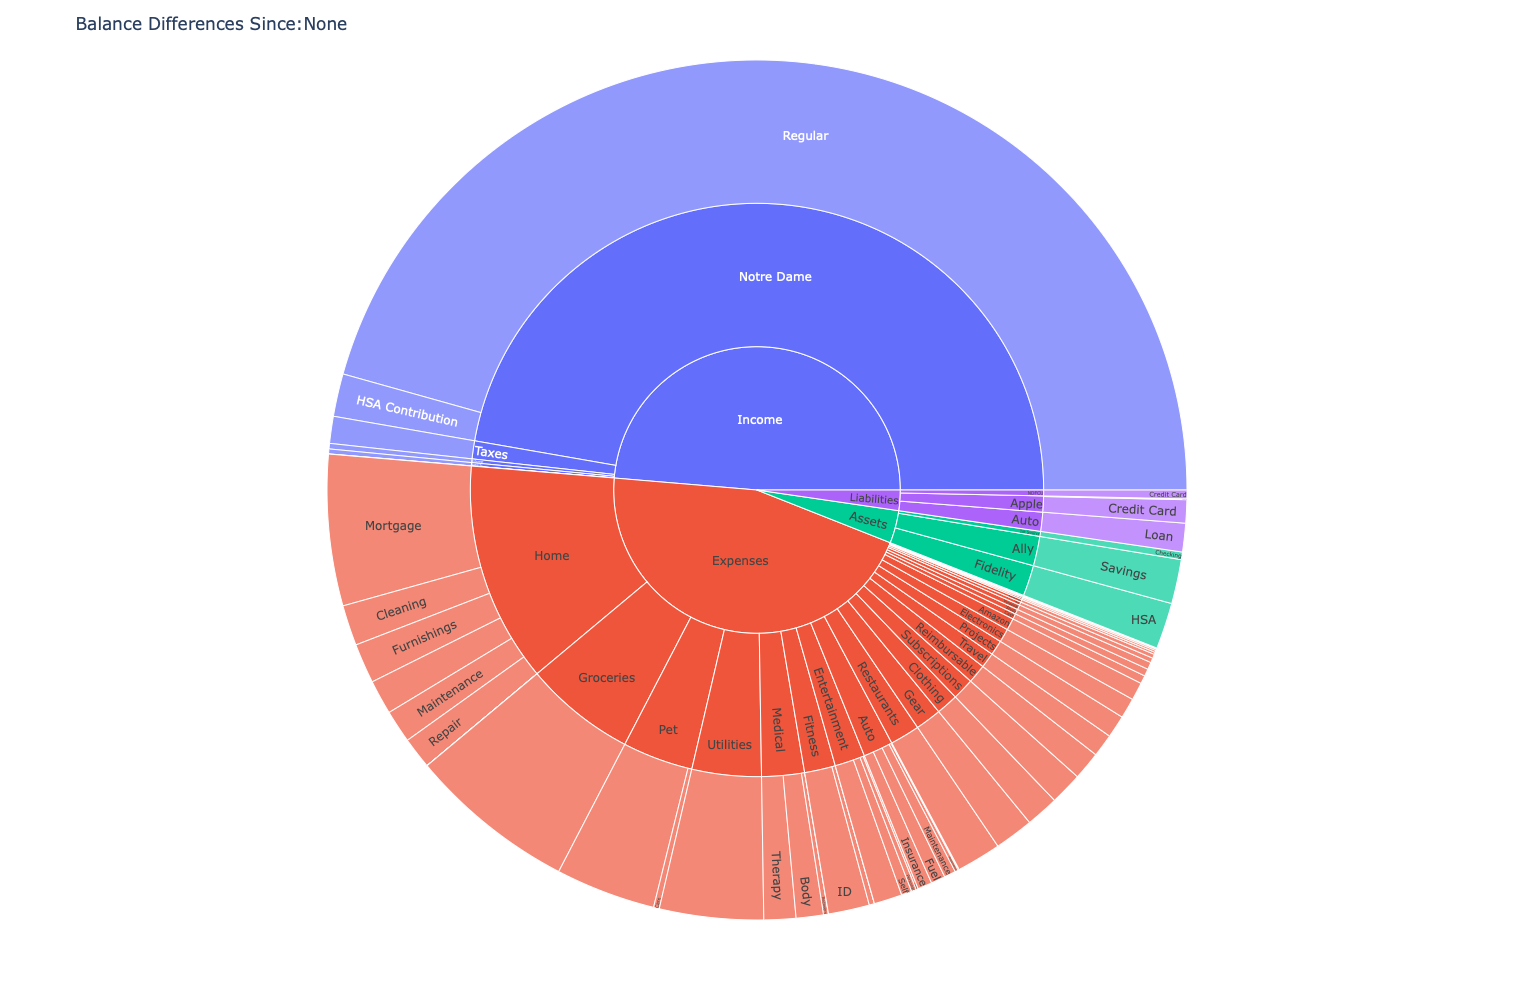

In [17]:
#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
#cb = ci.balances(ledgers)
#cb
df = br
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                   "Difference": df["Difference"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
df = df.loc[df["Type"] != "Equity"]
df = df.fillna("")
df = df.replace(np.inf,0)
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Difference")
sbfig.update_layout(height=1000, title=f"Balance Differences Since:{str(start_date)}")
sbfig.show()
#sbfig.data

In [18]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))

In [19]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


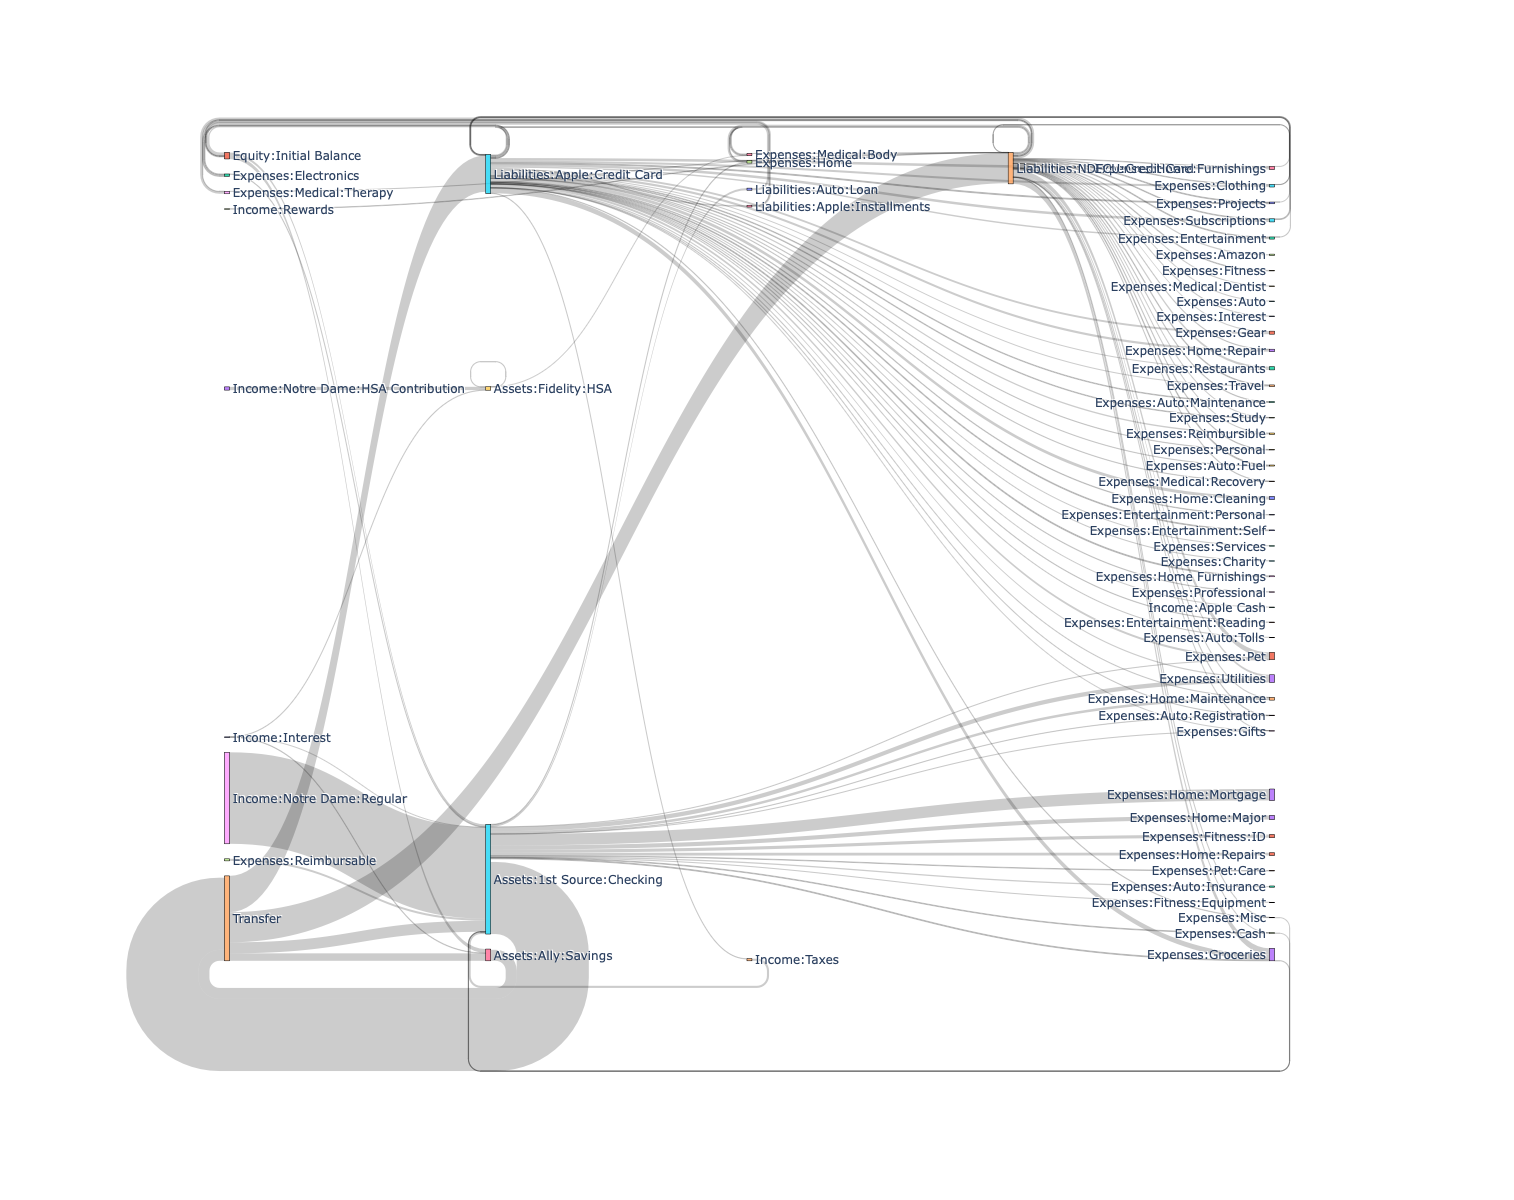

In [20]:
f.update_layout(height=1200)
f.show()

In [21]:
monthly_sum = lw0.groupby(ACCT_NAMES + ["Date"]).sum().groupby(ACCT_NAMES + [pd.Grouper(freq="ME", level=-1)])["Incoming Amount"].sum()
px.scatter(monthly_sum.loc[("Expenses", "Electronics", "")], y="Incoming Amount")

monthly_mean = monthly_sum.groupby(ACCT_NAMES).mean()

In [22]:
monthly_mean

Type         Account           Subaccount      
Assets       1st Source        Checking              181.87
             Ally              Savings                43.97
             Fidelity          HSA                   200.62
Equity       Initial Balance                        -123.44
Expenses     Amazon                                   77.89
             Auto                                      0.28
                               Fuel                   62.82
                               Insurance              75.57
                               Maintenance            50.61
                               Registration           30.40
                               Tolls                   4.78
             Cash                                     38.49
             Charity                                   4.68
             Clothing                                144.47
             Electronics                             126.09
             Entertainment                          

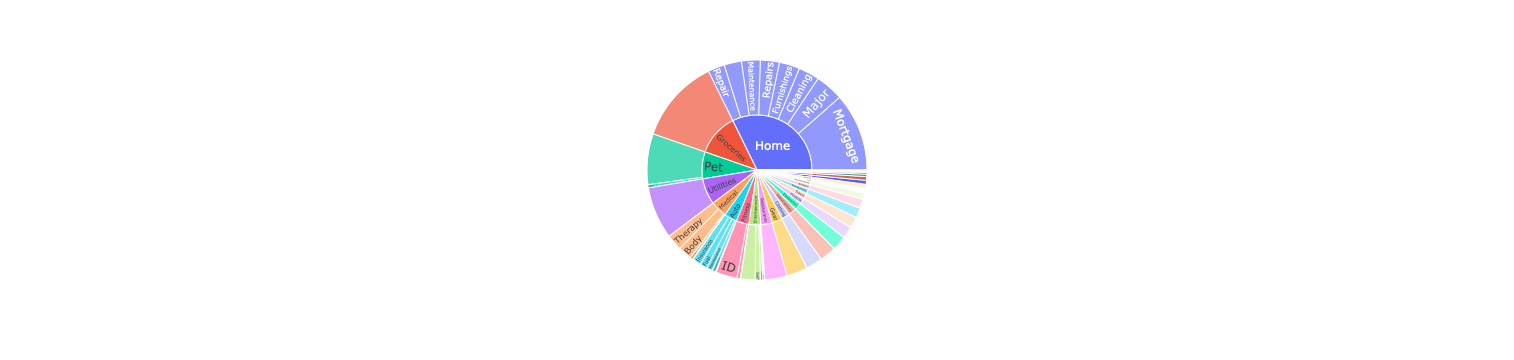

In [23]:
mean_expenses = monthly_mean["Expenses"]
remaining = mean_expenses.sum() + monthly_mean["Income"].sum()
monthly = pd.concat([mean_expenses, pd.Series(data=-1 * remaining, index=pd.MultiIndex.from_tuples([("Remaining", "", "")]))], axis="rows")
monthly.index.names=["Account", "Subaccount"]
monthly.name="Total"
px.sunburst(monthly.reset_index(), path=["Account", "Subaccount"], values="Total")

In [24]:
trans[trans.From == "Expenses:Utilities"]

Date                                        Description  Amount  \
17   2022-01-05  AMZN MKTP US*ET0DT6QC3   . AMZN.COM/BILL. WA 0000  -17.12   
25   2022-01-12                          VERIZON WIRELESS PAYMENTS -107.88   
31   2022-01-14                          AEP INDIANA MICH BILL PAY -101.15   
35   2022-01-14  CITY OF SOUTH BEND       . 574-223-0311 . IN 0000  -88.80   
39   2022-01-16  AMZN MKTP US*HU2BX13K3   . AMZN.COM/BILL. WA 0000  -85.96   
40   2022-01-18                                   NIPSCO UTIL PYMT  -97.63   
44   2022-01-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
42   2022-01-19  AMZN MKTP US*6R6UT2VB3   . AMZN.COM/BILL. WA 0000  -26.62   
59   2022-01-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -13.99   
71   2022-02-04                          AEP INDIANA MICH BILL PAY -105.87   
77   2022-02-07                                   NIPSCO UTIL PYMT -123.45   
82   2022-02-10                          VERIZON WIRELESS PAYMENTS -107.84   
83   2022-02-10  AMZN MKTP US*0M9N85U13   . AMZN.COM/BILL. WA 0000  -36.38   
95   2022-02-16  AMZN MKTP US*D52LQ5NW3   . AMZN.COM/BILL. WA 0000 -101.95   
106  2022-02-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
104  2022-02-19  AMZN MKTP US*1I8LG4F11   . AMZN.COM/BILL. WA 0000  -17.11   
121  2022-02-28  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
138  2022-03-04                          AEP INDIANA MICH BILL PAY  -98.95   
137  2022-03-04  CITY OF SOUTH BEND       . 574-223-0311 . IN 0000 -137.83   
145  2022-03-07                                   NIPSCO UTIL PYMT -109.25   
149  2022-03-10                          VERIZON WIRELESS PAYMENTS -107.84   
167  2022-03-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
192  2022-03-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
222  2022-04-07  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE...  -77.55   
224  2022-04-08                          AEP INDIANA MICH BILL PAY  -98.83   
233  2022-04-11                                   NIPSCO UTIL PYMT  -82.66   
236  2022-04-12                          VERIZON WIRELESS PAYMENTS -107.84   
255  2022-04-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
291  2022-04-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
316  2022-05-03  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE...  -81.05   
327  2022-05-05                          AEP INDIANA MICH BILL PAY  -98.05   
324  2022-05-05                                   NIPSCO UTIL PYMT  -74.38   
335  2022-05-11                          VERIZON WIRELESS PAYMENTS -107.80   
358  2022-05-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
382  2022-05-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
383  2022-05-31  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE...  -81.05   
397  2022-06-01                          AEP INDIANA MICH BILL PAY -102.32   
402  2022-06-02                                   NIPSCO UTIL PYMT  -31.13   
425  2022-06-10                          VERIZON WIRELESS PAYMENTS -145.76   
440  2022-06-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
456  2022-06-26  CITY OF SOUTH BEND       . 574-233-0311 . IN 0000  -81.05   
465  2022-06-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
491  2022-07-05                          AEP INDIANA MICH BILL PAY -129.10   
506  2022-07-07                                   NIPSCO UTIL PYMT  -22.34   
519  2022-07-12                          VERIZON WIRELESS PAYMENTS -107.80   
538  2022-07-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000  -93.98   
565  2022-07-29  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE...  -83.80   
574  2022-07-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000  -15.49   
583  2022-08-01                          AEP INDIANA MICH BILL PAY -124.66   
591  2022-08-02                                   NIPSCO UTIL PYMT  -19.90   
612  2022-08-10                  

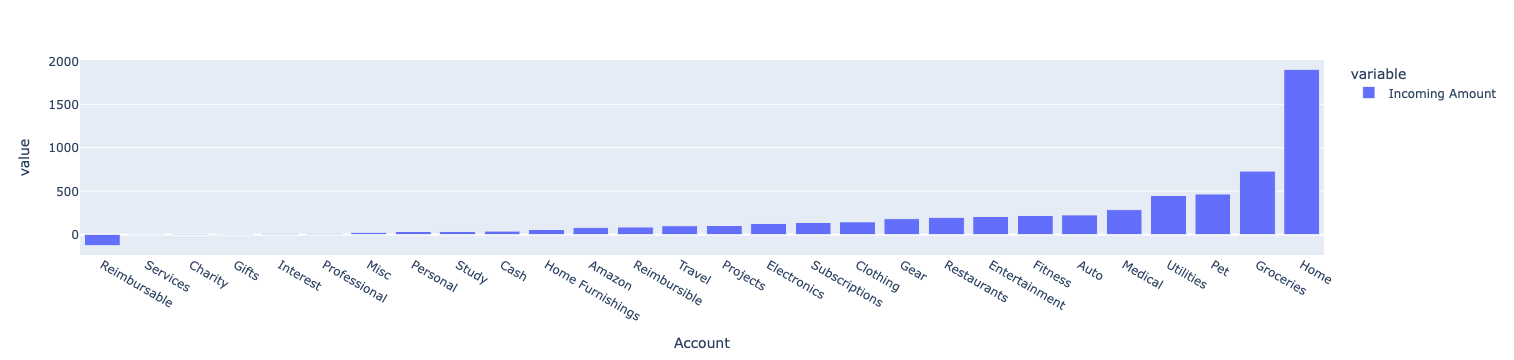

In [25]:
df = monthly_mean["Expenses"].groupby(["Account"]).sum().sort_values()
px.bar(df)

In [26]:
pmsum = monthly_sum["Expenses"]#.reset_index()
#pmsum["Acctstr"] = pmsum["Account"] + ":" + pmsum["Subaccount"]
#pmsum["Date"] = pmsum["Date"].astype(object).apply(pd.Period.to_timestamp)

In [27]:
pmsum=pmsum.reorder_levels(["Date", "Account", "Subaccount"])

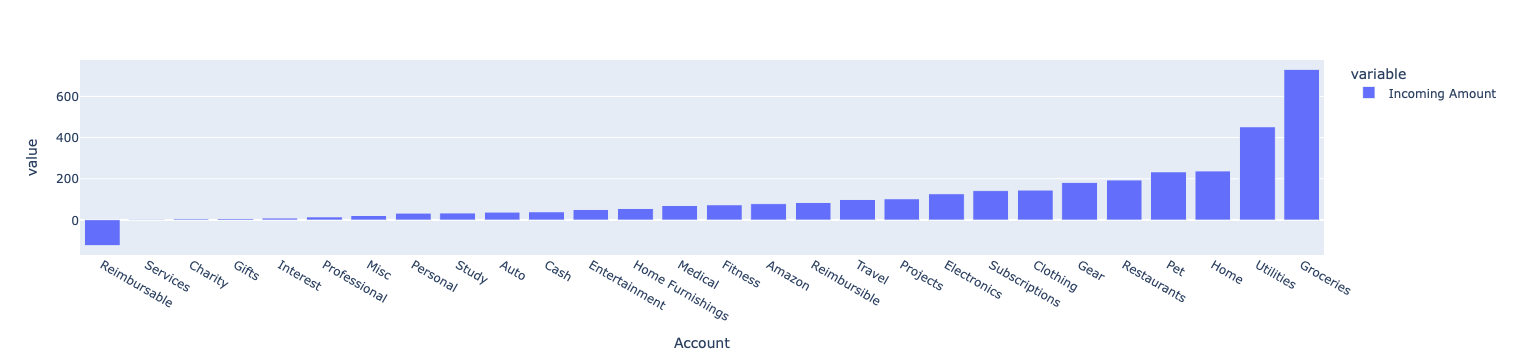

In [28]:
df = monthly_sum["Expenses"]
#px.bar(df.sort_values())
df = df.groupby("Account").mean()
px.bar(df.sort_values())

In [29]:
pdextension = pd.period_range(start = pmsum.index.levels[0][-1], end=pd.Period("2024-12"), freq="M")[1:]

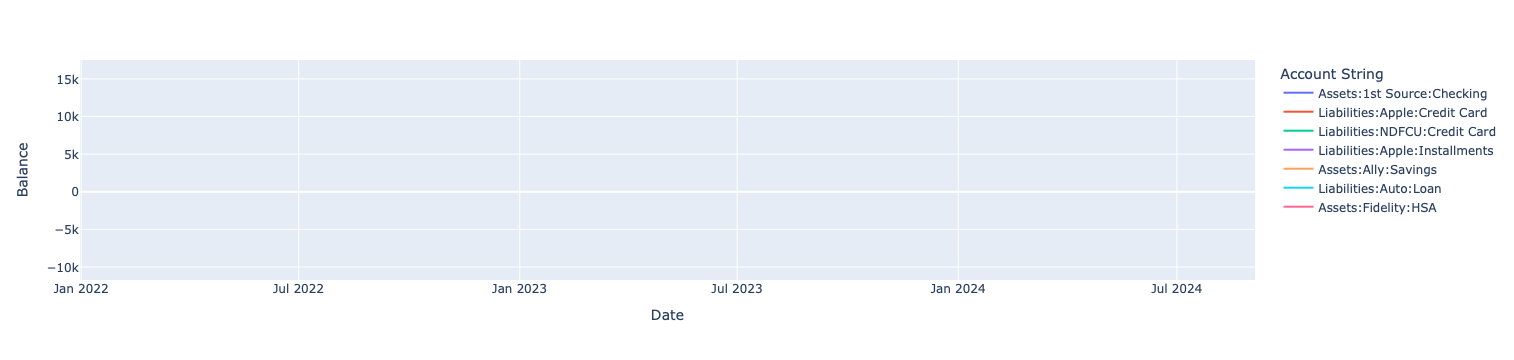

In [30]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])], x="Date", y="Balance", color="Account String")

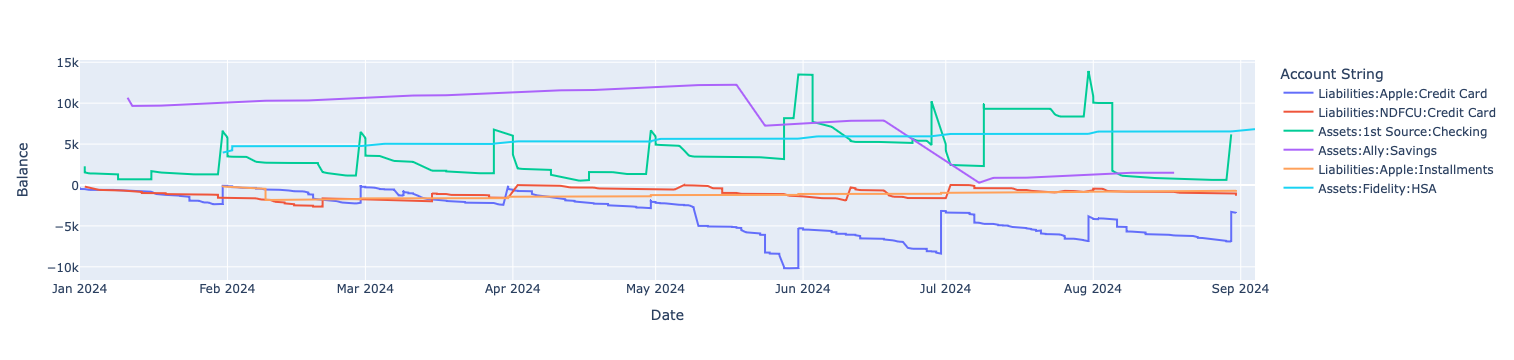

In [31]:
exp = ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])]
px.line(exp[exp["Date"] >= pd.Timestamp(2024, 1, 1)], x="Date", y="Balance", color="Account String")

In [32]:
budget = {}
for idx in pdextension:
    budget[idx] = monthly_mean
budget = pd.DataFrame(budget)

In [33]:
btrans = pd.DataFrame(budget.T.stack(["Account", "Subaccount"])).rename(columns={0:"Amount"})
#help(btrans.index)
#btrans["Account String"] = [":".join(("Expenses", a, b)) for a, b in zip(btrans.index.get_level_values("Account"),
#                                                           btrans.index.get_level_values("Subaccount"))]
#btrans=btrans.droplevel("Account")
#btrans=btrans.droplevel("Subaccount")

#def stripcolon(s):
#    if s.endswith(":"):
#        return s[:-1]
#    else:
#        return s
#btrans["To"] = btrans["Account String"].apply(stripcolon)

/var/folders/42/qqsltqsj6fl30wl4xm41gs4m0000gn/T/ipykernel_95905/1351139105.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [34]:
endassets = br.loc["Assets"]["End Balance"]
endliabilities = br.loc["Liabilities"]["End Balance"]

In [35]:
start = pd.DataFrame(pd.concat([endassets, endliabilities])).rename(columns={"End Balance": "Balance"})

In [36]:
start["Description"] = "Ending Balance"

In [37]:
expsum = btrans.groupby(level=0).sum()
#expsum["Balance"] = expsum.cumsum()

In [38]:
expsum

Type     Assets  Equity  Expenses    Income  Liabilities  Transfer
2024-10  426.47 -123.44  5,721.18 -5,757.59      -159.60   -107.02
2024-11  426.47 -123.44  5,721.18 -5,757.59      -159.60   -107.02
2024-12  426.47 -123.44  5,721.18 -5,757.59      -159.60   -107.02

In [39]:
dfs = {}
keep = ["Date", "Description", "Account String"]
accts = []
for typ in ["Assets", "Liabilities", "Transfer"]:
    accts.append(pd.unique(ledgers[ledgers["Type"] == typ]["Account String"]))
accts = np.concatenate(accts)

bals = []
grouped = ledgers.groupby("Account String")
for acct in accts:
    bals.append(grouped.get_group(acct)["Balance"].rename("Balance " + acct))

balance_table=pd.concat([ledgers[keep], pd.concat(bals, axis="columns")], join="inner", axis="columns").sort_values("Date").ffill().fillna(0)

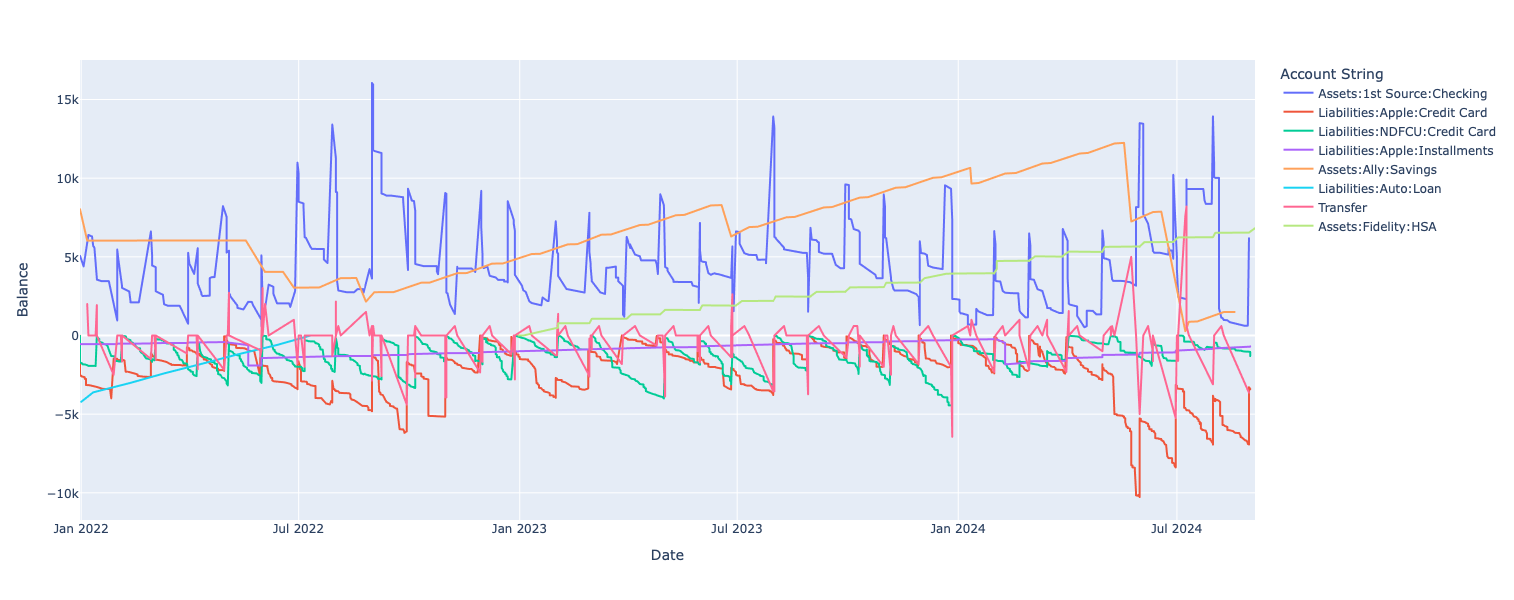

In [40]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities", "Transfer"])].set_index("Date"),
        y="Balance", color="Account String", height=600)

In [41]:
asgrouped = ledgers.groupby("Account String")["Incoming Amount"].sum()
asgrouped.name="Asset String"
tpgrouped = ledgers.groupby("Transaction Pair")["Incoming Amount"].sum()
tpgrouped.name="Transaction Pair"

In [42]:
check = pd.concat([asgrouped,-1 *  tpgrouped], axis="columns")#.rename(columns={"Incoming Amount"Asset String", 1:"Transaction Pair"})

In [43]:
check

Asset String  Transaction Pair
Assets:1st Source:Checking              6,183.68          6,183.68
Assets:Ally:Savings                     1,495.04          1,495.04
Assets:Fidelity:HSA                     6,821.21          6,821.21
Equity:Initial Balance                 -4,197.12         -4,197.12
Expenses:Amazon                         2,648.20          2,648.20
Expenses:Auto                               9.62              9.62
Expenses:Auto:Fuel                      2,135.99          2,135.99
Expenses:Auto:Insurance                 2,569.32          2,569.32
Expenses:Auto:Maintenance               1,720.86          1,720.86
Expenses:Auto:Registration              1,033.69          1,033.69
Expenses:Auto:Tolls                       162.44            162.44
Expenses:Cash                           1,308.50          1,308.50
Expenses:Charity                          159.20            159.20
Expenses:Clothing                       4,912.15          4,912.15
Expenses:Electronics                    4,286.89          4,286.89
Expenses:Entertainment                  4,162.89          4,162.89
Expenses:Entertainment:Personal           768.23            768.23
Expenses:Entertainment:Reading            464.81            464.81
Expenses:Entertainment:Self             1,617.11          1,617.11
Expenses:Fitness                          998.00            998.00
Expenses:Fitness:Equipment                100.00            100.00
Expenses:Fitness:ID                     6,300.00          6,300.00
Expenses:Gear                           6,135.25          6,135.25
Expenses:Gifts                            227.52            227.52
Expenses:Groceries                     24,802.89         24,802.89
Expenses:Home                           5,089.56          5,089.56
Expenses:Home Furnishings               1,916.29          1,916.29
Expenses:Home:Cleaning                  6,155.00          6,155.00
Expenses:Home:Furnishings               6,022.89          6,022.89
Expenses:Home:Maintenance               5,512.36          5,512.36
Expenses:Home:Major                     8,284.00          8,284.00
Expenses:Home:Mortgage                 22,970.90         22,970.90
Expenses:Home:Repair                    4,894.82          4,894.82
Expenses:Home:Repairs                   5,600.00          5,600.00
Expenses:Interest                         295.78            295.78
Expenses:Medical:Body                   4,053.63          4,053.63
Expenses:Medical:Dentist                  114.00            114.00
Expenses:Medical:Recovery                 775.97            775.97
Expenses:Medical:Therapy                4,737.64          4,737.64
Expenses:Misc                             698.52            698.52
Expenses:Personal                       1,105.13          1,105.13
Expenses:Pet                           14,891.77         14,891.77
Expenses:Pet:Care                         935.00            935.00
Expenses:Professional                     475.88            475.88
Expenses:Projects                       3,456.23          3,456.23
Expenses:Reimbursable                  -4,184.19         -4,184.19
Expenses:Reimbursible                   2,907.51          2,907.51
Expenses:Restaurants                    6,576.68          6,576.68
Expenses:Services                          59.95             59.95
Expenses:Study                          1,126.42          1,126.42
Expenses:Subscriptions                  4,804.94          4,804.94
Expenses:Travel                         3,371.05          3,371.05
Expenses:Utilities                     15,348.74         15,348.74
Income:Apple Cash                          26.06             26.06
Income:Interest                          -818.34           -818.34
Income:Notre Dame:HSA Contribution     -6,583.20         -6,583.20
Income:Notre Dame:Regular            -183,763.08       -183,763.08
Income:Rewards                           -748.37           -748.37
Income:Taxes                           -3,871.00         -3,871.00
Liabilities:Appl

In [44]:
check[check["Asset String"] != check["Transaction Pair"]].assign(Diff=check["Asset String"] - check["Transaction Pair"])

Asset String  Transaction Pair  Diff
Expenses:Auto:Fuel                  2,135.99          2,135.99  0.00
Expenses:Home                       5,089.56          5,089.56  0.00
Liabilities:Apple:Credit Card      -3,424.48         -3,424.48  0.00
Liabilities:Apple:Installments       -686.69           -686.69  0.00
Liabilities:NDFCU:Credit Card      -1,315.17         -1,315.17 -0.00

In [45]:
final_balance = ledgers.groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [46]:
monthly_incoming = lw0.set_index(["Date"]).sort_index().groupby(ACCT_NAMES).resample("ME")["Incoming Amount"].sum()

In [47]:
this_year_inc = monthly_incoming.loc[(slice(None), slice(None), slice(None), slice(pd.Timestamp("2023-12-31"), pd.Timestamp("2024-05-31")))]

In [48]:
end_of_2023_bals = lw0.set_index(["Date"]).sort_index()[:pd.Timestamp("2023-12-31")].groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [49]:
meaningful_eo23_bals = end_of_2023_bals.loc[["Assets", "Liabilities", "Transfer"]]

In [50]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card      -284.77
                         Installments     -249.80
             Auto        Loan               -0.00
             NDFCU       Credit Card       -99.77
Transfer                                    -0.00
Name: Incoming Amount, dtype: float64

In [51]:
budget.loc[["Income"]]

2024-10   2024-11   2024-12
Type   Account    Subaccount                                    
Income Apple Cash                       0.77      0.77      0.77
       Interest                       -24.07    -24.07    -24.07
       Notre Dame HSA Contribution   -193.62   -193.62   -193.62
                  Regular          -5,404.80 -5,404.80 -5,404.80
       Rewards                        -22.01    -22.01    -22.01
       Taxes                         -113.85   -113.85   -113.85

In [52]:
tot_exp_2024_to_date=this_year_inc["Expenses"].sum()
print(tot_exp_2024_to_date)

38068.15

In [53]:
tot_inc_2024_to_date=this_year_inc["Income"].sum()
print(-1*tot_inc_2024_to_date)

35578.689999999995

In [54]:
-1 * tot_inc_2024_to_date - tot_exp_2024_to_date

-2489.4600000000064

In [55]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card      -284.77
                         Installments     -249.80
             Auto        Loan               -0.00
             NDFCU       Credit Card       -99.77
Transfer                                    -0.00
Name: Incoming Amount, dtype: float64

In [56]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]]

Type         Account     Subaccount  
Assets       1st Source  Checking        6,183.68
             Ally        Savings         1,495.04
             Fidelity    HSA             6,821.21
Liabilities  Apple       Credit Card    -3,424.48
                         Installments     -686.69
             Auto        Loan               -0.00
             NDFCU       Credit Card    -1,315.17
Transfer                                -3,638.57
Name: Incoming Amount, dtype: float64

In [57]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]].sum() - meaningful_eo23_bals.sum()

-10248.539999999995

In [58]:
rem_income = budget.loc[[("Income", "Notre Dame", "Regular"), ("Income", "Apple Cash", "")]]
rem_income

2024-10   2024-11   2024-12
Type   Account    Subaccount                              
Income Notre Dame Regular    -5,404.80 -5,404.80 -5,404.80
       Apple Cash                 0.77      0.77      0.77

In [59]:
budget[pd.Period("2024-10")].loc[("Expenses", "Amazon")]

Subaccount
   77.89
Name: 2024-10, dtype: float64

In [60]:
budget

2024-10   2024-11   2024-12
Type        Account          Subaccount                                    
Assets      1st Source       Checking            181.87    181.87    181.87
            Ally             Savings              43.97     43.97     43.97
            Fidelity         HSA                 200.62    200.62    200.62
Equity      Initial Balance                     -123.44   -123.44   -123.44
Expenses    Amazon                                77.89     77.89     77.89
            Auto                                   0.28      0.28      0.28
                             Fuel                 62.82     62.82     62.82
                             Insurance            75.57     75.57     75.57
                             Maintenance          50.61     50.61     50.61
                             Registration         30.40     30.40     30.40
                             Tolls                 4.78      4.78      4.78
            Cash                                  38.49     38.49     38.49
            Charity                                4.68      4.68      4.68
            Clothing                             144.47    144.47    144.47
            Electronics                          126.09    126.09    126.09
            Entertainment                        122.44    122.44    122.44
                             Personal             22.59     22.59     22.59
                             Reading              13.67     13.67     13.67
                             Self                 47.56     47.56     47.56
            Fitness                               29.35     29.35     29.35
                             Equipment             2.94      2.94      2.94
                             ID                  185.29    185.29    185.29
            Gear                                 180.45    180.45    180.45
            Gifts                                  6.69      6.69      6.69
            Groceries                            729.50    729.50    729.50
            Home                                 149.69    149.69    149.69
                             Cleaning            181.03    181.03    181.03
                             Furnishings         177.14    177.14    177.14
                             Maintenance         162.13    162.13    162.13
                             Major               243.65    243.65    243.65
                             Mortgage            675.61    675.61    675.61
                             Repair              143.97    143.97    143.97
                             Repairs             164.71    164.71    164.71
            Home Furnishings                      56.36     56.36     56.36
            Interest                               8.70      8.70      8.70
            Medical          Body                119.22    119.22    119.22
                             Dentist               3.35      3.35      3.35
                             Recovery             22.82     22.82     22.82
                             Therapy             139.34    139.34    139.34
            Misc                                  20.54     20.54     20.54
            Personal                              32.50     32.50     32.50
            Pet                                  437.99    437.99    437.99
                             Care                 27.50     27.50     27.50
            Professional                          14.00     14.00     14.00
            Projects                             101.65    101.65    101.65
            Reimbursable                        -123.06   -123.06   -123.06
            Reimbursible                          85.51     85.51     85.51
            Restaurants                          193.43    193.43    193.43
            Services                               1.76      1.76      1.76
            Study                                 33.13     33.13     33.13
            Subscriptions                        141.32    141.32    141.32
            Travel  

In [61]:
trans.to_csv(PRODUCTSPTH / "transactions.csv")
len(trans)

2978

In [62]:
balance_table

Date                                        Description  \
0    2021-12-31                                    Initial Balance   
1    2021-12-31  FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...   
2    2021-12-31  PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000   
3    2021-12-31  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000   
4    2021-12-31                                    Initial Balance   
...         ...                                                ...   
5953 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5947 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5946 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5948 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5954 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                      Account String  Balance Assets:1st Source:Checking  \
0         Assets:1st Source:Checking                            5,067.54   
1      Liabilities:Apple:Credit Card                            5,067.54   
2      Liabilities:NDFCU:Credit Card                            5,067.54   
3      Liabilities:NDFCU:Credit Card                            5,067.54   
4      Liabilities:NDFCU:Credit Card                            5,067.54   
...                              ...                                 ...   
5953   Liabilities:NDFCU:Credit Card                            6,183.68   
5947  Liabilities:Apple:Installments                            6,183.68   
5946   Liabilities:Apple:Credit Card                            6,183.68   
5948  Liabilities:Apple:Installments                            6,183.68   
5954             Assets:Fidelity:HSA                            6,183.68   

      Balance Assets:Ally:Savings  Balance Assets:Fidelity:HSA  \
0                            0.00                         0.00   
1                            0.00                         0.00   
2                            0.00                         0.00   
3                            0.00                         0.00   
4                            0.00                         0.00   
...                           ...                          ...   
5953                     1,495.04                     6,542.05   
5947                     1,495.04                     6,542.05   
5946                     1,495.04                     6,542.05   
5948                     1,495.04                     6,542.05   
5954                     1,495.04                     6,821.21   

      Balance Liabilities:Apple:Credit Card  \
0                                      0.00   
1                                    -11.04   
2                                    -11.04   
3                                    -11.04   
4                                    -11.04   
...                                     ...   
5953                              -3,424.48   
5947                              -3,424.48   
5946                              -3,401.23   
5948                              -3,401.23   
5954                              -3,401.23   

      Balance Liabilities:NDFCU:Credit Card  \
0                                      0.00   
1                                      0.00   
2                                    -26.93   
3                                   -113.88   
4                                 -1,721.42   
...                                     ...   
5953                              -1,315.17   
5947                              -1,315.17   
5946                              -1,315.17   
5948                              -1,315.17   
5954                              -1,315.17   

      Balance Liabilities:Apple:Installments  Balance Liabilities:Auto:Loan  \
0                                       0.00                           0.00   
1                                       0.00                           0.00   
2                                       0.00                           0.00   
3                 

In [63]:
ledgers.to_csv(PRODUCTSPTH / "ledgers.csv")


In [64]:
ty = ledgers[ledgers["Date"] >= pd.Timestamp(2024, 1, 1)]
ty["Month"] = ty["Date"].apply(lambda d: d.month)
ty = ty.sort_values("Date")
tyg = ty.groupby(["Type", "Account", "Subaccount", "Month"])["Incoming Amount"].sum()

In [65]:
print(len(tyg))
tyg.unstack()


267

Month                                              1         2         3  \
Type        Account       Subaccount                                       
Assets      1st Source    Checking          4,232.77    -65.24    280.69   
            Ally          Savings            -363.90    635.82    635.45   
            Fidelity      HSA                  16.76    797.39    300.41   
Expenses    Amazon                             14.99     17.98    125.05   
            Auto          Fuel                 40.37     80.40     47.26   
                          Insurance              NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Registration           NaN       NaN    231.42   
                          Tolls               127.50       NaN       NaN   
            Clothing                          481.50       NaN       NaN   
            Electronics                          NaN  1,648.00       NaN   
            Entertainment                      56.18    198.05    156.51   
                          Personal               NaN     19.95       NaN   
                          Reading              12.99      8.55       NaN   
                          Self                157.53     46.85     66.88   
            Fitness       ID                  225.00    225.00    225.00   
            Gear                              101.65       NaN    230.00   
            Gifts                             125.00       NaN       NaN   
            Groceries                         806.34    597.66    653.52   
            Home                              237.35       NaN     98.34   
                          Cleaning            278.00    278.00    278.00   
                          Furnishings            NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Major                  NaN       NaN       NaN   
                          Mortgage            746.58    746.58    746.58   
                          Repair                 NaN       NaN       NaN   
            Interest                            8.84     44.33     16.49   
            Medical       Body                107.35    115.04     84.84   
                          Recovery               NaN       NaN    255.94   
                          Therapy             132.46    273.08       NaN   
            Misc                                 NaN       NaN     79.00   
            Personal                             NaN     45.50     42.00   
            Pet                               542.78    126.27    308.52   
                          Care                   NaN    125.00       NaN   
            Projects                             NaN       NaN       NaN   
            Reimbursable                         NaN       NaN       NaN   
            Reimbursible                         NaN    597.89       NaN   
            Restaurants                       148.08    345.20    174.17   
            Services                             NaN       NaN     59.95   
            Study                              77.92     80.48     41.16   
            Subscriptions                     116.98    165.30    174.75   
            Travel                               NaN    107.10       NaN   
            Utilities                         562.61    541.18    393.33   
Income      Apple Cash                           NaN       NaN     18.90   
            Interest                          -52.95    -54.22    -56.87   
            Notre Dame    HSA Contribution       NaN   -779.16   -279.16   
                          Regular          -5,335.70 -5,335.70 -5,335.70   
            Rewards                           -76.50    -25.50       NaN   
            Taxes                                NaN       NaN       NaN   
Liabilities Apple         Credit Card         190.26   -119.86   -282.62   
                          Installments         6

In [66]:
ty

Date                                        Description  \
4412 2024-01-01    WMMH 500 ARCHDALE DR. 800-628-0241 28217 NC USA   
4429 2024-01-01    WMMH 500 ARCHDALE DR. 800-628-0241 28217 NC USA   
4428 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4427 2024-01-01  PATREON* MEMBERSHIP 600 TOWNSEND 5TH FLOOR INT...   
4426 2024-01-01  AB* ABEBOOKS.CO K7JNI5410 TERRY AVENUE NORTH S...   
...         ...                                                ...   
5951 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5952 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5953 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5954 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   
5955 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                        Transaction Pair  Incoming Amount  \
4412         Expenses:Entertainment:Self           -14.99   
4429       Liabilities:Apple:Credit Card            14.99   
4428       Liabilities:Apple:Credit Card             9.99   
4427       Liabilities:Apple:Credit Card            27.19   
4426       Liabilities:Apple:Credit Card            48.83   
...                                  ...              ...   
5951       Liabilities:NDFCU:Credit Card           273.57   
5952      Liabilities:Apple:Installments           -23.25   
5953                        Expenses:Pet          -273.57   
5954  Income:Notre Dame:HSA Contribution           279.16   
5955                 Assets:Fidelity:HSA          -279.16   

                          Account String         Type        Account  \
4412       Liabilities:Apple:Credit Card  Liabilities          Apple   
4429         Expenses:Entertainment:Self     Expenses  Entertainment   
4428              Expenses:Subscriptions     Expenses  Subscriptions   
4427              Expenses:Entertainment     Expenses  Entertainment   
4426                      Expenses:Study     Expenses          Study   
...                                  ...          ...            ...   
5951                        Expenses:Pet     Expenses            Pet   
5952       Liabilities:Apple:Credit Card  Liabilities          Apple   
5953       Liabilities:NDFCU:Credit Card  Liabilities          NDFCU   
5954                 Assets:Fidelity:HSA       Assets       Fidelity   
5955  Income:Notre Dame:HSA Contribution       Income     Notre Dame   

            Subaccount   Balance  Month  
4412       Credit Card   -299.76      1  
4429              Self  1,116.38      1  
4428                    3,615.02      1  
4427                    3,245.22      1  
4426                      711.30      1  
...                ...       ...    ...  
5951                   14,891.77      8  
5952       Credit Card -3,424.48      8  
5953       Credit Card -1,315.17      8  
5954               HSA  6,821.21      9  
5955  HSA Contribution -6,583.20      9  

[1544 rows x 10 columns]

In [67]:
pd.Period("2024-01")

Period('2024-01', 'M')

In [68]:
"1,2,3".split(",")

['1', '2', '3']

In [69]:
bm = ledgers
bm["Period"] = bm["Date"].apply(lambda d: pd.Period(f"{d.year}-{d.month}"))
bm = bm.groupby(["Type", "Account", "Subaccount", "Period"], dropna=False ).tail(1)
bm = bm.sort_values(["Type", "Account", "Subaccount", "Period"])
bm = bm.set_index(["Type", "Account", "Subaccount", "Period"])["Balance"]
#bm.loc[["Assets"]]
bm.unstack().ffill(axis="columns")
#ledgers[ledgers["Subaccount"] == "Equipment"]

Period                                          2021-12   2022-01   2022-02  \
Type        Account          Subaccount                                       
Assets      1st Source       Checking          5,067.54  5,463.93  6,614.48   
            Ally             Savings           8,028.68  6,031.73  6,034.29   
            Fidelity         HSA                    NaN       NaN       NaN   
Equity      Initial Balance                   -8,413.83 -4,197.12 -4,197.12   
Expenses    Amazon                                  NaN    221.00    233.99   
            Auto                                    NaN      9.62      9.62   
                             Fuel                 26.93     59.06     92.07   
                             Insurance              NaN       NaN       NaN   
                             Maintenance            NaN       NaN     14.00   
                             Registration           NaN       NaN       NaN   
                             Tolls                  NaN       NaN       NaN   
            Cash                                    NaN    100.00    100.00   
            Charity                                 NaN       NaN       NaN   
            Clothing                                NaN     63.88     63.88   
            Electronics                             NaN       NaN       NaN   
            Entertainment                         11.04     28.04    143.43   
                             Personal               NaN       NaN     34.95   
                             Reading                NaN       NaN       NaN   
                             Self                   NaN       NaN       NaN   
            Fitness                                 NaN    225.00    548.00   
                             Equipment              NaN       NaN       NaN   
                             ID                     NaN       NaN       NaN   
            Gear                                    NaN    973.65  1,693.65   
            Gifts                                   NaN       NaN       NaN   
            Groceries                             86.95    619.31  1,274.10   
            Home                                    NaN      5.99     11.98   
                             Cleaning               NaN       NaN       NaN   
                             Furnishings            NaN       NaN       NaN   
                             Maintenance            NaN       NaN       NaN   
                             Major                  NaN       NaN       NaN   
                             Mortgage               NaN    674.34  1,348.68   
                             Repair                 NaN       NaN       NaN   
                             Repairs                NaN       NaN       NaN   
            Home Furnishings                        NaN       NaN       NaN   
            Interest                                NaN       NaN       NaN   
            Medical          Body                   NaN    560.86    647.03   
                             Dentist                NaN       NaN       NaN   
                             Recovery               NaN       NaN       NaN   
                             Therapy                NaN     70.00    140.00   
            Misc                                    NaN      9.16      9.16   
            Personal                                NaN     36.00     70.00   
            Pet                                     NaN    123.08    246.16   
                             Care                   NaN       NaN     90.00   
            Professional                            NaN       NaN       NaN   
            Projects                                NaN       NaN       NaN   
            Reimbursable                            NaN       NaN       NaN   
            Reimbursible                            NaN       NaN       NaN   
            Restaurants                             NaN       NaN     54.13   
            Services                              

In [70]:
ndfcu = ndfcu.sort_values(["Date", "Balance"], ignore_index=True)
ndfcu["Period"] = ndfcu.sort_values("Date").Date.apply(lambda d: pd.Period(f"{d.year}-{d.month}"))
ndfcu

Date              Note  \
0    2021-12-31    CC SALES DRAFT   
1    2021-12-31    CC SALES DRAFT   
2    2022-01-01    CC SALES DRAFT   
3    2022-01-02    CC SALES DRAFT   
4    2022-01-02    CC SALES DRAFT   
...         ...               ...   
1103 2024-08-24    CC SALES DRAFT   
1104 2024-08-26    CC SALES DRAFT   
1105 2024-08-30    CC SALES DRAFT   
1106 2024-08-31    CC SALES DRAFT   
1107 2024-08-31  FIN CHG PURCHASE   

                                            Description  Amount  Balance  \
0     MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000  -86.95 1,694.49   
1     PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000  -26.93 1,721.42   
2     CVS/PHARMACY #08642      . SOUTH BEND   . IN 0000  -24.70 1,746.12   
3     MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000  -47.38 1,793.50   
4     CROSSFIT SOUTH BEND      . MISHAWAKA    . IN 0000  -38.00 1,831.50   
...                                                 ...     ...      ...   
1103  Amazon.com*R46IV         . Amzn.com/bill. WA 0...  -21.39   991.28   
1104  AMAZON MARK* RK0         . HTTPSAMAZON.C. WA 0...  -25.63 1,016.91   
1105  Netflix.com              . netflix.com  . CA 0000  -15.49 1,032.40   
1106  CHEWY.COM                . 800-672-4399 . FL 0000 -273.57 1,305.97   
1107                                                      -9.20 1,315.17   

                        From   Period  
0         Expenses:Groceries  2021-12  
1         Expenses:Auto:Fuel  2021-12  
2      Expenses:Medical:Body  2022-01  
3         Expenses:Groceries  2022-01  
4         Expenses:Groceries  2022-01  
...                      ...      ...  
1103         Expenses:Amazon  2024-08  
1104         Expenses:Amazon  2024-08  
1105  Expenses:Subscriptions  2024-08  
1106            Expenses:Pet  2024-08  
1107       Expenses:Interest  2024-08  

[1108 rows x 7 columns]

In [71]:
df = ledgers[ledgers["Account String"] == "Liabilities:NDFCU:Credit Card"].sort_values("Date").groupby("Period").tail(1)
for (i, row) in df.iterrows():
    print(row["Date"], row["Balance"])
    for j, nr in ndfcu[ndfcu["Balance"] == round(-1*row["Balance"],2)].iterrows():
        print(nr["Date"], nr["Balance"])
    print("---")

2021-12-31 00:00:00 -1721.42

2021-12-31 00:00:00 1721.42

---

2022-01-30 00:00:00 -1615.48

2022-01-30 00:00:00 1615.48

---

2022-02-28 00:00:00 -1522.59

2022-02-28 00:00:00 1522.59

---

2022-03-31 00:00:00 -2146.8

2022-03-31 00:00:00 2146.8

---

2022-04-30 00:00:00 -2713.59

2022-04-30 00:00:00 2713.59

---

2022-05-31 00:00:00 -3009.71

2022-05-31 00:00:00 3009.71

2022-05-31 00:00:00 3009.71

---

2022-06-30 00:00:00 -1986.92

2022-06-30 00:00:00 1986.92

2022-07-03 00:00:00 1986.92

---

2022-07-31 00:00:00 -2315.3199999999997

2022-07-31 00:00:00 2315.32

---

2022-08-31 00:00:00 -2573.0099999999998

2022-08-31 00:00:00 2573.01

---

2022-09-30 00:00:00 -3119.359999999999

2022-09-30 00:00:00 3119.36

---

2022-10-31 00:00:00 -1641.9499999999996

2022-10-30 00:00:00 1641.95

2022-10-31 00:00:00 1641.95

---

2022-11-30 00:00:00 -1684.5799999999995

2022-11-30 00:00:00 1684.58

---

2022-12-31 00:00:00 -76.78999999999954

2022-12-31 00:00:00 76.79

---

2023-01-31 00:00:00 -1376.1999999999996

2023-01-31 00:00:00 1376.2

2023-02-01 00:00:00 1376.2

---

2023-02-28 00:00:00 -885.5099999999995

2023-02-28 00:00:00 885.51

---

2023-03-31 00:00:00 -2519.5199999999995

2023-03-31 00:00:00 2519.52

---

2023-04-30 00:00:00 -3924.0099999999998

2023-04-30 00:00:00 3924.01

---

2023-05-31 00:00:00 -351.4799999999994

2023-05-31 00:00:00 351.48

---

2023-06-30 00:00:00 -1393.6499999999992

2023-06-30 00:00:00 1393.65

---

2023-07-31 00:00:00 -3147.2599999999993

2023-07-31 00:00:00 3147.26

---

2023-08-31 00:00:00 -69.78999999999948

2023-08-31 00:00:00 69.79

---

2023-09-30 00:00:00 -1564.1599999999994

---

2023-10-30 00:00:00 -2492.8899999999994

2023-10-30 00:00:00 2492.89

---

2023-11-30 00:00:00 -2085.08

2023-11-30 00:00:00 2085.08

---

2023-12-31 00:00:00 -99.77

2023-12-31 00:00:00 99.77

---

2024-01-31 00:00:00 -1565.79

2024-01-31 00:00:00 1565.79

---

2024-02-29 00:00:00 -1758.27

2024-02-29 00:00:00 1758.27

---

2024-03-31 00:00:00 -1570.4

2024-03-31 00:00:00 1570.4

---

2024-04-30 00:00:00 -501.39

2024-04-30 00:00:00 501.39

---

2024-05-30 00:00:00 -1322.1299999999999

2024-05-30 00:00:00 1322.13

---

2024-06-30 00:00:00 -1610.4099999999999

2024-07-01 00:00:00 1610.41

---

2024-07-30 00:00:00 -848.6699999999998

2024-07-30 00:00:00 848.67

---

2024-08-31 00:00:00 -1315.1699999999998

2024-08-31 00:00:00 1315.17

---

In [72]:
ndfcu[ndfcu["Period"] == pd.Period("2024-08")]

Date              Note  \
1094 2024-08-01         CC REWARD   
1095 2024-08-01         CC REWARD   
1096 2024-08-03    CC SALES DRAFT   
1097 2024-08-04    CC SALES DRAFT   
1098 2024-08-08    CC SALES DRAFT   
1099 2024-08-15    CC SALES DRAFT   
1100 2024-08-18    CC SALES DRAFT   
1101 2024-08-19    CC SALES DRAFT   
1102 2024-08-24    CC SALES DRAFT   
1103 2024-08-24    CC SALES DRAFT   
1104 2024-08-26    CC SALES DRAFT   
1105 2024-08-30    CC SALES DRAFT   
1106 2024-08-31    CC SALES DRAFT   
1107 2024-08-31  FIN CHG PURCHASE   

                                            Description  Amount  Balance  \
1094                                                     200.00   448.67   
1095                                                     200.00   648.67   
1096  NYTimes*NYTimes          . 800-698-4637 . NY 0000  -16.00   464.67   
1097  CHEWY.COM                . 800-672-4399 . FL 0000 -273.57   738.24   
1098  AMAZON.COM*RM68A         . SEATTLE      . WA 0...  -83.25   821.49   
1099  Amazon Prime*RU9         . Amzn.com/bill. WA 0...  -14.99   836.48   
1100  AMAZON PRIME*RU7         . amzn.com/bill. WA 0...   -2.99   839.47   
1101  COMCAST CHICAGO          . 800-COMCAST  . IL 0000 -107.05   946.52   
1102  AMAZON RETA* R45         . WWW.AMAZON.CO. WA 0...  -23.37   969.89   
1103  Amazon.com*R46IV         . Amzn.com/bill. WA 0...  -21.39   991.28   
1104  AMAZON MARK* RK0         . HTTPSAMAZON.C. WA 0...  -25.63 1,016.91   
1105  Netflix.com              . netflix.com  . CA 0000  -15.49 1,032.40   
1106  CHEWY.COM                . 800-672-4399 . FL 0000 -273.57 1,305.97   
1107                                                      -9.20 1,315.17   

                        From   Period  
1094          Income:Rewards  2024-08  
1095          Income:Rewards  2024-08  
1096  Expenses:Subscriptions  2024-08  
1097            Expenses:Pet  2024-08  
1098         Expenses:Amazon  2024-08  
1099         Expenses:Amazon  2024-08  
1100         Expenses:Amazon  2024-08  
1101      Expenses:Utilities  2024-08  
1102         Expenses:Amazon  2024-08  
1103         Expenses:Amazon  2024-08  
1104         Expenses:Amazon  2024-08  
1105  Expenses:Subscriptions  2024-08  
1106            Expenses:Pet  2024-08  
1107       Expenses:Interest  2024-08

In [88]:
df = ledgers[ledgers["Account String"] == "Liabilities:NDFCU:Credit Card"]
df[df["Period"] == pd.Period("2024-08")]

Date                                        Description  \
5778 2024-08-01                                                      
5779 2024-08-01                                                      
5803 2024-08-03  NYTimes*NYTimes          . 800-698-4637 . NY 0000   
5807 2024-08-04  CHEWY.COM                . 800-672-4399 . FL 0000   
5833 2024-08-08  AMAZON.COM*RM68A         . SEATTLE      . WA 0...   
5866 2024-08-15  Amazon Prime*RU9         . Amzn.com/bill. WA 0...   
5872 2024-08-18  AMAZON PRIME*RU7         . amzn.com/bill. WA 0...   
5876 2024-08-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000   
5892 2024-08-24  Amazon.com*R46IV         . Amzn.com/bill. WA 0...   
5893 2024-08-24  AMAZON RETA* R45         . WWW.AMAZON.CO. WA 0...   
5903 2024-08-26  AMAZON MARK* RK0         . HTTPSAMAZON.C. WA 0...   
5933 2024-08-30  Netflix.com              . netflix.com  . CA 0000   
5947 2024-08-31                                                      
5951 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   

            Transaction Pair  Incoming Amount                 Account String  \
5778          Income:Rewards           200.00  Liabilities:NDFCU:Credit Card   
5779          Income:Rewards           200.00  Liabilities:NDFCU:Credit Card   
5803  Expenses:Subscriptions           -16.00  Liabilities:NDFCU:Credit Card   
5807            Expenses:Pet          -273.57  Liabilities:NDFCU:Credit Card   
5833         Expenses:Amazon           -83.25  Liabilities:NDFCU:Credit Card   
5866         Expenses:Amazon           -14.99  Liabilities:NDFCU:Credit Card   
5872         Expenses:Amazon            -2.99  Liabilities:NDFCU:Credit Card   
5876      Expenses:Utilities          -107.05  Liabilities:NDFCU:Credit Card   
5892         Expenses:Amazon           -21.39  Liabilities:NDFCU:Credit Card   
5893         Expenses:Amazon           -23.37  Liabilities:NDFCU:Credit Card   
5903         Expenses:Amazon           -25.63  Liabilities:NDFCU:Credit Card   
5933  Expenses:Subscriptions           -15.49  Liabilities:NDFCU:Credit Card   
5947       Expenses:Interest            -9.20  Liabilities:NDFCU:Credit Card   
5951            Expenses:Pet          -273.57  Liabilities:NDFCU:Credit Card   

             Type Account   Subaccount   Balance   Period  
5778  Liabilities   NDFCU  Credit Card   -633.18  2024-08  
5779  Liabilities   NDFCU  Credit Card   -433.18  2024-08  
5803  Liabilities   NDFCU  Credit Card   -449.18  2024-08  
5807  Liabilities   NDFCU  Credit Card   -722.75  2024-08  
5833  Liabilities   NDFCU  Credit Card   -806.00  2024-08  
5866  Liabilities   NDFCU  Credit Card   -820.99  2024-08  
5872  Liabilities   NDFCU  Credit Card   -823.98  2024-08  
5876  Liabilities   NDFCU  Credit Card   -931.03  2024-08  
5892  Liabilities   NDFCU  Credit Card   -952.42  2024-08  
5893  Liabilities   NDFCU  Credit Card   -975.79  2024-08  
5903  Liabilities   NDFCU  Credit Card -1,001.42  2024-08  
5933  Liabilities   NDFCU  Credit Card -1,016.91  2024-08  
5947  Liabilities   NDFCU  Credit Card -1,026.11  2024-08  
5951  Liabilities   NDFCU  Credit Card -1,299.68  2024-08

# a

In [73]:
len(trans)

2978

In [74]:
len(ledgers)

5956

In [79]:
ledgers[ledgers["Type"] == Transfer]

NameError: name 'Transfer' is not defined